In [52]:
# auto reload
import _utils

%reload_ext autoreload
%autoreload 2

In [53]:
import numpy as np 
import pandas as pd
import os
DATASET_PATH = './data'

In [84]:
# for dirname, _, filenames in os.walk(DATASET_PATH):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [85]:
import PIL
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [86]:
import torch
import torchvision.datasets as dset
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Device

# Dataset

In [87]:
IMG_H = 200
IMG_W = 200

In [88]:
data_processing = _utils.data_processing(IMG_H, IMG_W)
dataset = data_processing.data_norm(DATASET_PATH)

In [89]:
dataset

Dataset ImageFolder
    Number of datapoints: 746
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [61]:
split_ratio = 0.2
test_size = int(split_ratio * len(dataset))
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(
    dataset=dataset, 
    lengths = [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# load dataset to data_processing api
data_processing.load_dataset(train_dataset, test_dataset)

In [62]:
test_dataset

In [63]:
final_train_dataset = data_processing.data_aug(degrees = 5, scale = (1.1, 1.1), shear = 0.9)

# Models 

### Model - 1

In [90]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.model = nn.Sequential(
              
              nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5,padding=1),  
              nn.BatchNorm2d(128),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2), 

              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,padding=0), 
              nn.BatchNorm2d(256),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2), 

              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5,padding=0),
              nn.BatchNorm2d(512),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2,stride=2),  

              nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3,padding=0), 
              nn.BatchNorm2d(1024),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2,),  

              nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=5,padding=1),
              nn.BatchNorm2d(2048),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2,stride=2),
            
            
              nn.Flatten() ,
              nn.Dropout(0.5),  
            
                nn.Linear(in_features= 32768, out_features=1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(in_features=1024, out_features=256),
                nn.ReLU(),
                nn.Linear(in_features=256, out_features=64),
                nn.ReLU(),
                nn.Linear(in_features=64, out_features=1),
                nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [91]:
import torchvision.models as models

### Resnet18

In [133]:
class resnet_model(nn.Module):
    def __init__(self):
        super(resnet_model, self).__init__()
        self.model = models.resnet18(weights="DEFAULT")
        # self.model = models.wide_resnet101_2(weights="DEFAULT")
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.fc = nn.Sequential(
            nn.Linear(1000, 2028),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2028, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [134]:
from torch.utils.data import Dataset, DataLoader, random_split

# Training

In [197]:
MODEL_PATH = './best_model.pt'

In [212]:
BATCH_SIZE = 32
small_dataset = False

### Small dataset split ###

if small_dataset:
    num_train = len(final_train_dataset)
    final_train_dataset_tmp, _ = random_split(final_train_dataset, [500, num_train-500])
else:
    final_train_dataset_tmp = final_train_dataset

###########################

valid_split = 0.2
num_train = len(final_train_dataset_tmp)
split = int(np.floor(valid_split * num_train))

train_loader, valid_loader = random_split(final_train_dataset_tmp, [num_train-split, split])

train_loader = DataLoader(train_loader, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_loader, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([32, 3, 200, 200])
torch.Size([32])


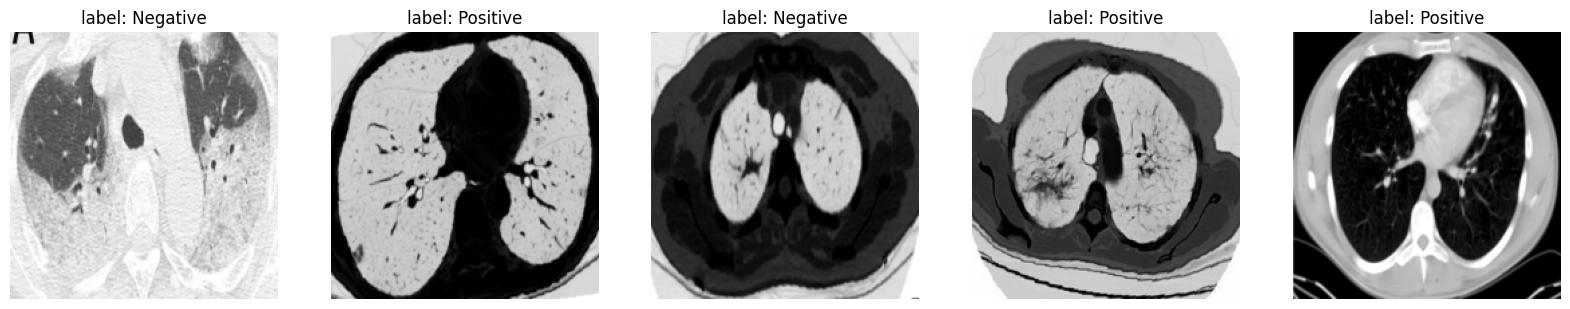

In [213]:
for img, label in train_loader:
    break

print(img.shape)
print(label.shape)

# plot images
imgs = 5 if 5<BATCH_SIZE else BATCH_SIZE
fig, ax = plt.subplots(1, imgs, figsize=(20, 10))
for i in range(imgs):
    tmp = img[i].permute(1, 2, 0)
    tmp += 1.
    tmp *= 255./2.
    tmp = tmp.numpy().astype(int)
    ax[i].imshow(tmp, cmap='nipy_spectral')
    ax[i].axis('off')
    title_name = "label: " + ("Positive" if label[i].item() == 1 else "Negative")
    ax[i].set_title(title_name)
plt.show()

In [230]:
model = resnet_model().to(DEVICE)
# model = cnn_model().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

model

resnet_model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [231]:
from _utils import train, eval, load_from_checkpoint, save_to_checkpoint

In [232]:
checkpoint_dir = "./checkpoints/"

best_acc = 0
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

In [233]:
# load from checkpoints if needed

EPOCHS = 20
ACC_THRESHOLD = 0.5

filepath = checkpoint_dir
start_epoch = 0
model, optimizer, start_epoch, (train_acc, train_loss, valid_acc, valid_loss, best_acc) = \
    load_from_checkpoint(model, optimizer, filepath = filepath)

# training
for epoch in range(start_epoch, EPOCHS):
    print('=== Epoch', epoch+1, '/', EPOCHS, '===')
    loss, acc = train(model, train_loader, criterion, optimizer, acc_threshold = ACC_THRESHOLD)
    train_loss.append(loss)
    train_acc.append(acc)

    val_loss, val_acc = eval(model, valid_loader, criterion, acc_threshold = ACC_THRESHOLD)
    valid_loss.append(val_loss)
    valid_acc.append(val_acc)
    save_to_checkpoint(model, optimizer, epoch+1, train_acc, train_loss, valid_acc, valid_loss, best_acc, filepath = filepath)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print('[WEIGHTS SAVED]')

    print('loss: {:.2f}'.format(loss), 'acc: {:.2f}%'.format(acc), 'val_loss: {:.2f}'.format(val_loss), 'val_acc: {:.2f}%'.format(val_acc))

=> no checkpoint found at './checkpoints/checkpoints'
=== Epoch 1 / 20 ===
training:

100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


[WEIGHTS SAVED]
loss: 0.66 acc: 0.62% val_loss: 0.63 val_acc: 0.63%
=== Epoch 2 / 20 ===
training:

100%|██████████| 30/30 [00:28<00:00,  1.07it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


[WEIGHTS SAVED]
loss: 0.62 acc: 0.71% val_loss: 0.65 val_acc: 0.68%
=== Epoch 3 / 20 ===
training:

100%|██████████| 30/30 [00:35<00:00,  1.19s/it]


evaluating:

100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


[WEIGHTS SAVED]
loss: 0.61 acc: 0.73% val_loss: 0.60 val_acc: 0.70%
=== Epoch 4 / 20 ===
training:

100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


[WEIGHTS SAVED]
loss: 0.60 acc: 0.75% val_loss: 0.59 val_acc: 0.71%
=== Epoch 5 / 20 ===
training:

100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


[WEIGHTS SAVED]
loss: 0.60 acc: 0.78% val_loss: 0.58 val_acc: 0.77%
=== Epoch 6 / 20 ===
training:

100%|██████████| 30/30 [00:29<00:00,  1.03it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


loss: 0.61 acc: 0.76% val_loss: 0.62 val_acc: 0.74%
=== Epoch 7 / 20 ===
training:

100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


loss: 0.61 acc: 0.76% val_loss: 0.60 val_acc: 0.77%
=== Epoch 8 / 20 ===
training:

100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


loss: 0.61 acc: 0.74% val_loss: 0.58 val_acc: 0.75%
=== Epoch 9 / 20 ===
training:

100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


loss: 0.58 acc: 0.80% val_loss: 0.59 val_acc: 0.73%
=== Epoch 10 / 20 ===
training:

100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


loss: 0.60 acc: 0.75% val_loss: 0.59 val_acc: 0.77%
=== Epoch 11 / 20 ===
training:

100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


[WEIGHTS SAVED]
loss: 0.59 acc: 0.80% val_loss: 0.59 val_acc: 0.78%
=== Epoch 12 / 20 ===
training:

100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


loss: 0.59 acc: 0.78% val_loss: 0.60 val_acc: 0.77%
=== Epoch 13 / 20 ===
training:

100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


loss: 0.59 acc: 0.78% val_loss: 0.61 val_acc: 0.67%
=== Epoch 14 / 20 ===
training:

100%|██████████| 30/30 [00:32<00:00,  1.08s/it]


evaluating:

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


loss: 0.58 acc: 0.81% val_loss: 0.59 val_acc: 0.76%
=== Epoch 15 / 20 ===
training:

100%|██████████| 30/30 [00:32<00:00,  1.09s/it]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


loss: 0.58 acc: 0.82% val_loss: 0.59 val_acc: 0.77%
=== Epoch 16 / 20 ===
training:

100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


evaluating:

100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


[WEIGHTS SAVED]
loss: 0.57 acc: 0.82% val_loss: 0.58 val_acc: 0.79%
=== Epoch 17 / 20 ===
training:

100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


evaluating:

100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


[WEIGHTS SAVED]
loss: 0.58 acc: 0.80% val_loss: 0.57 val_acc: 0.79%
=== Epoch 18 / 20 ===
training:

100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


evaluating:

100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


loss: 0.57 acc: 0.83% val_loss: 0.59 val_acc: 0.75%
=== Epoch 19 / 20 ===
training:

100%|██████████| 30/30 [00:39<00:00,  1.32s/it]


evaluating:

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


loss: 0.59 acc: 0.78% val_loss: 0.58 val_acc: 0.79%
=== Epoch 20 / 20 ===
training:

100%|██████████| 30/30 [00:36<00:00,  1.20s/it]


evaluating:

100%|██████████| 8/8 [00:07<00:00,  1.13it/s]

loss: 0.57 acc: 0.84% val_loss: 0.59 val_acc: 0.76%


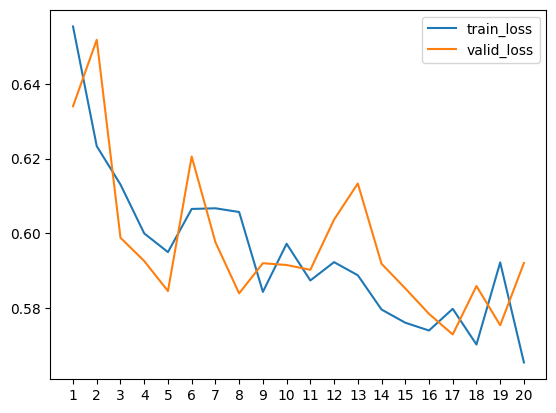

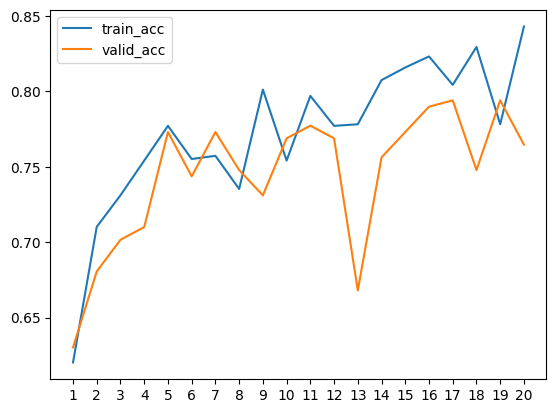

In [234]:
# plot loss

xtick = np.arange(1, EPOCHS+1, 1)
plt.plot(xtick, train_loss, label='train_loss')
plt.plot(xtick, valid_loss, label='valid_loss')
plt.xticks(xtick)
plt.legend()
plt.show()

# plot accuracy
plt.plot(xtick, train_acc, label='train_acc')
plt.plot(xtick, valid_acc, label='valid_acc')
plt.xticks(xtick)
plt.legend()
plt.show()

# Testing

In [235]:
from _utils import test
import datetime

In [238]:
# test

model = resnet_model().to(DEVICE)
model.load_state_dict(torch.load('best_model.pth'))
criterion = nn.BCEWithLogitsLoss()

test_loss, test_acc, matrix = test(model, test_loader, criterion, acc_threshold = ACC_THRESHOLD)
now = datetime.datetime.now()

print("test time:", now.strftime("%Y-%m-%d %H:%M:%S"))
print('test_loss: {:.2f}'.format(test_loss), 'test_acc: {:.2f}%'.format(test_acc))

100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

test time: 2023-05-25 16:25:42
test_loss: 0.61 test_acc: 0.73%


# Confision Matrix

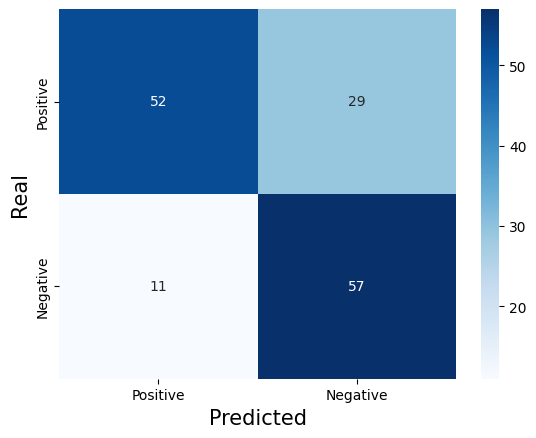

In [239]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# matrix is a tuple of (tp, tn, fp, fn)
cm = np.array([[matrix[0], matrix[3]], [matrix[2], matrix[1]]])
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('Real', fontsize=15)
plt.xticks([0.5, 1.5], ['Positive', 'Negative'])
plt.yticks([0.5, 1.5], ['Positive', 'Negative'])
plt.show()